# SHAP for explainability of  HEP classifiers
## Events classification using DNN
***

Raquel Pezoa, Luis Salinas, Claudio Torres (UV, CCTVal, UTFSM, Valparaíso Chile)



In [57]:
import pandas as pd
import shap
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import keras

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit, logit

import mplhep as hep

## Data
***
- Data is obtained from: https://www.openml.org/d/23512
- Each event is represented by a set of 28 features, including 21 low-level features corresponding to physics properties measured by the detector, and 7 high-level features derived from the previous ones.
- Some of the event's features:

|Type| Variable  | Description   |
|---| --- | --- |
|low-level|lepton pT |  Momentum of the lepton|
|low-level|lepton eta | Pseudorapidity eta of the lepton|
|low-level|lepton phi | Azimuthal angle phi of the lepton|
|low-level|Missing energy magnitude | Energy not detected|
|| ... | ...|
|high-level|m_jlv| Mass jet ($j$), lepton ($l$, electrons or muons), neutrino $\nu$| 
|high-level|m_bb| Mass quarks $b$|	
|high-level|m_wbb| Mass boson $W$ and quarks $b$|
|high-level|m_wwbb|Mass bosons $W$ and quarks $b$|



- More detailes in Baldi, P., Sadowski, P., & Whiteson, D. (2014). Searching for exotic particles in high-energy physics with deep learning. Nature communications, 5(1), 1-9 [(link)](https://www.nature.com/articles/ncomms5308).
- **Problem:** Binary classification of HEP events, to indentify signal from background.
 - signal: $gg \rightarrow H^0 \rightarrow W^{\mp} H^{\pm} \rightarrow W^{\mp} W^{\pm} h^0 \rightarrow W^{\mp} W^{\pm} b \bar{b}$. 
 This signal process is the fusion of two gluons into a heavy electrically neutral Higgs boson ($gg \rightarrow H^0 $), which decays to a heavy electrically-charged Higgs bosons ($H^{\pm}$) and a $W$ boson. The $H^{\pm}$ boson subsequently decays to a second $W$ boson and the light Higgs boson, $h^0$. The light Higgs boson decays predominantly to a pair of bottom quarks, giving the process.

In [ ]:
seed_=420
# Read data file
df = pd.read_csv("../data/higgs/phpZLgL9q.csv")
df.rename(columns = {'class': 'label'}, inplace = True)
# Removing last row containinng "?" values
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df = df.apply(pd.to_numeric)
# Pandas dataframe for correlation matrix without label column
df_corr = df.drop('label', inplace=False, axis=1)

In [123]:
df.describe()["m_bb"]

count    98049.000000
mean         0.973207
std          0.522968
min          0.048125
25%          0.674055
50%          0.874083
75%          1.140051
max         11.994177
Name: m_bb, dtype: float64

In [124]:
df.describe()["m_wwbb"]

count    98049.000000
mean         0.959432
std          0.313487
min          0.350939
25%          0.770026
50%          0.871170
75%          1.057654
max          6.015647
Name: m_wwbb, dtype: float64

In [58]:
# Scaling data
y = df["label"]
X = df.iloc[:,1:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled_data, columns=X.columns)


# Training, validation, and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, test_size=0.2, random_state=seed_)

## Loading DNN classification model previously trained
***

- The model was generated using Python [Talos](https://autonomio.github.io/talos/#/) and [Keras](https://keras.io)
- We performed hyperparameter tuning, obtaining the follwing parameters values:
 - lr': 1, 'batch_size': 512, 'epochs': 100, 'dropout': 0, 'optimizer': Adam, 'loss': 'binary_crossentropy', 'shapes': 'brick', 'first_neuron': 64, 'hidden_layers': 4, 'activation': 'relu', 'last_activation': 'sigmoid', 'weight_regulizer': None}





In [60]:
model2 = keras.models.load_model("DNN_model.h5")

## Prediction
***

In [61]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

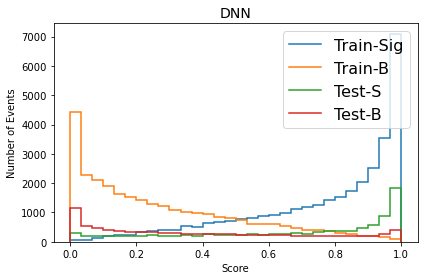

In [62]:
# Score distribution
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_signal_train, bins_sig_train = np.histogram(y_pred_train[y_train == 1], bins=30)
h_back_train, bins_back_train = np.histogram(y_pred_train[y_train == 0], bins=30)
h_sig_test, bins_sig_test = np.histogram(y_pred_test[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_test[y_test == 0], bins=30)

axs.set_title("DNN", fontsize=14)
hep.histplot([h_signal_train,h_back_train, h_sig_test, h_back_test], bins_sig_test, ax=axs,label=["Train-Sig", "Train-B", "Test-S", "Test-B"])
axs.legend(fontsize=16)
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")

plt.tight_layout()
plt.show()
#plot_name = "dist_plots/dnn/score_dist_{}_test.png".format(out_name)
#plt.savefig(plot_name)



In [63]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score as f1s

fpr, tpr, ths = roc_curve(y_test,  y_pred_test)
auc_ = auc(fpr, tpr)
f1 = f1s(y_test,  (y_pred_test>.5))
prec = precision_score(y_test,  (y_pred_test>.5))
rec = recall_score(y_test,  (y_pred_test>.5))
acc = accuracy_score(y_test,  (y_pred_test>.5))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.68  -- prec: 0.67  -- recall: 0.68  -- acc: 0.66


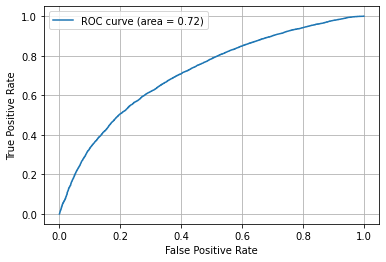

In [64]:
#create ROC curve
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

## SHAP
***

### DeepExplainer
- Method that approximates SHAP values for deep learning models.

In [65]:
start_time = time()
explainer = shap.DeepExplainer(model, X_test.to_numpy())
shap_values = explainer.shap_values(X_test.to_numpy())
elapsed_time = time() - start_time
print("Elapsed time: %0.5f seconds." % elapsed_time)

Elapsed time: 2234.10297 seconds.


In [66]:
# print the JS visualization code to the notebook
shap.initjs()

### Waterfall plot
*****
-  This plot show how  features contribute to push the classifier prediction from the base value (the average model prediction over the training dataset) to the model output, of an specific data sample.
- In this case, we are visualizing the SHAP values of the second sample of testing set (shap_values[0][1])
- Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. 
- We observe $m_{bb}$ and  $m_{wwbb}$ features push lower, with -0.3 and -0.01 SHAP values, respectively. The missing energy phi and jet 4 phi are pushing higher, with a +0.05 SHAP value. 
- Model prediction $f(x)=.006$, and base value $E[f(x)]= 0.544$
- Notice that $f(x)$ and $E[f(x)]$ values correspond to values on the logit space.

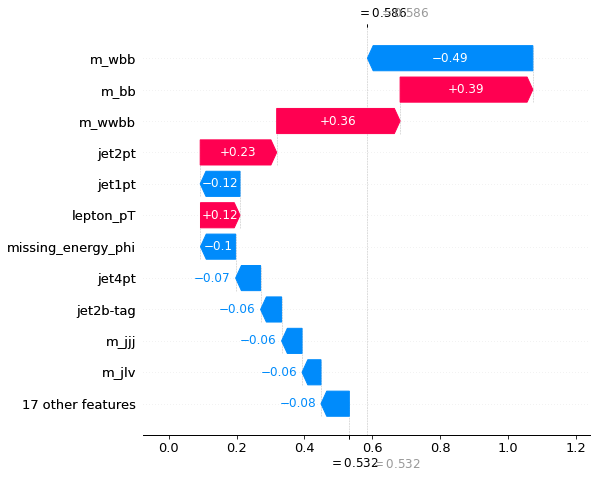

In [117]:
#https://github.com/slundberg/shap/issues/1420
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), 
                                       shap_values[0][4],
                                       feature_names = df.columns[1:], 
                                       show = True,
                                      max_display=12)

In [69]:
df.columns

Index(['label', 'lepton_pT', 'lepton_eta', 'lepton_phi',
       'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta',
       'jet1phi', 'jet1b-tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b-tag',
       'jet3pt', 'jet3eta', 'jet3phi', 'jet3b-tag', 'jet4pt', 'jet4eta',
       'jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb',
       'm_wbb', 'm_wwbb'],
      dtype='object')

In [70]:
print("SHAP Value m_bb: %.2f" %shap_values[0][1,-3])
print("SHAP Value m_wwbb: %.2f" %shap_values[0][1,-1])
print("SHAP Value missing energy phi: %.2f" %shap_values[0][1,4])

SHAP Value m_bb: -0.23
SHAP Value m_wwbb: -0.15
SHAP Value missing energy phi: 0.01


###  Force plots
*****
- Showing features contribution of the first testing data sample on model prediction
- By default for binary classification the SHAP values are displayed in the logit space.
- Force plot supports link='logit' to transform log odds to probabilities.

In [114]:
i=4
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][i],  X_test.iloc[i,:], link="logit")

Showing the force_plot as image
*****

In [115]:
#![force_plot_dnn_96.png](attachment:force_plot_dnn_96.png)

In [116]:
print("-- Sample's label:", y_test.iloc[i])
print("-- DNN prediction: %.2f" % y_pred_test[i,0])
print("-- Explainer expected value: %.4f" % explainer.expected_value[0])
print("-- DNN prediction: %.4f" % (shap_values[0][i].sum() + explainer.expected_value[0]))
print("-- DNN prediction: %.2f" % logit(expit(shap_values[0][i].sum() + explainer.expected_value[0]) ))
print("-- y_pred_test.mean(): %.4f" % y_pred_test.mean())

-- Sample's label: 1
-- DNN prediction: 0.59
-- Explainer expected value: 0.5325
-- DNN prediction: 0.5858
-- DNN prediction: 0.59
-- y_pred_test.mean(): 0.5325


In [90]:
i=0
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][i],  X_test.iloc[i,:])


Showing the force_plot as image
*****

In [91]:
#![force_plot_dnn_0.png](attachment:force_plot_dnn_0.png)

In [120]:
print("-- Sample's label:", y_test.iloc[i])
print("-- DNN prediction: %.2f" % y_pred_test[i,0])
print("-- Explainer expected value: %.4f" % explainer.expected_value[0])
print("-- DNN prediction: %.4f" % (shap_values[0][i].sum() + explainer.expected_value[0]))
print("-- DNN prediction: %.2f" % logit(expit(shap_values[0][i].sum() + explainer.expected_value[0]) ))
print("-- y_pred_test.mean(): %.4f" % y_pred_test.mean())

-- Sample's label: 1
-- DNN prediction: 0.59
-- Explainer expected value: 0.5325
-- DNN prediction: 0.5858
-- DNN prediction: 0.59
-- y_pred_test.mean(): 0.5325


In [119]:
start=0
end=10
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][start:end],  X_test.iloc[start:end,:], link="logit")

### Summary Plots
*****

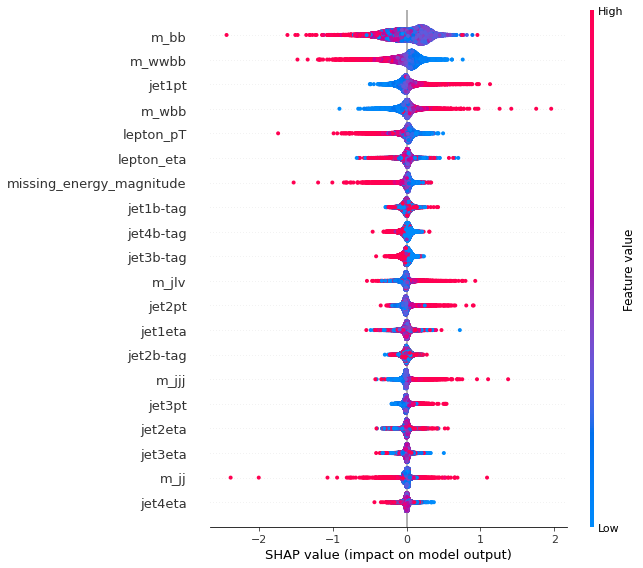

In [104]:
shap.summary_plot(shap_values[0], X_test, plot_type='dot')

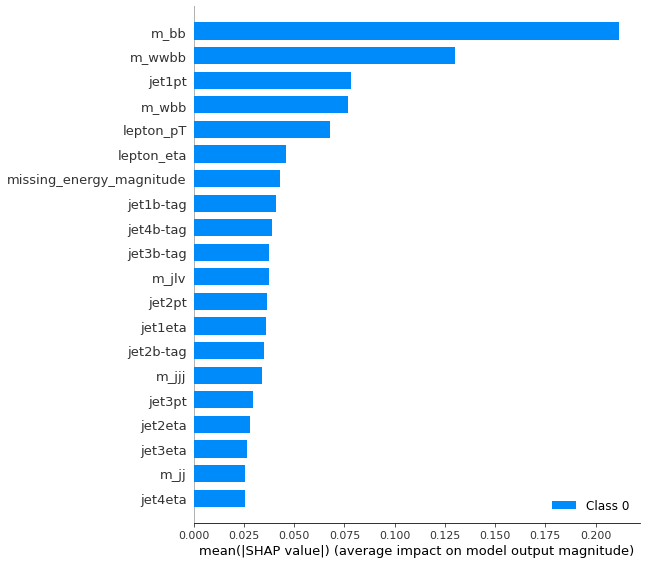

In [93]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Dependence Plot

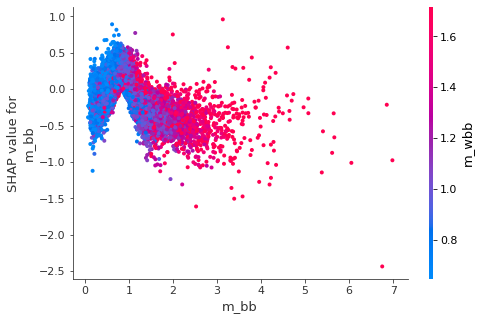

In [94]:
shap.dependence_plot("m_bb", shap_values[0],  X_test)

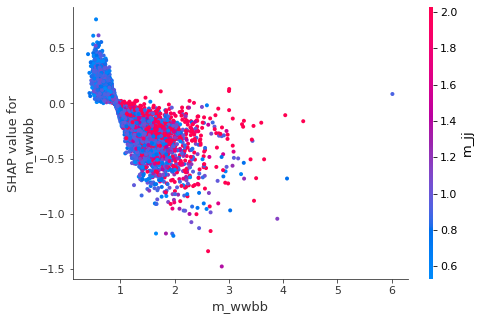

In [95]:
shap.dependence_plot("m_wwbb", shap_values[0],  X_test)

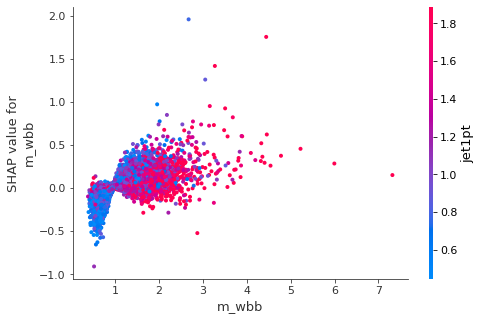

In [96]:
shap.dependence_plot("m_wbb", shap_values[0],  X_test)